# Crime and Penalty

In this data analysis, I will be analyzing and applying statistical practices on a dataset about the death penalty in the USA. 

## A/B Testing

A/B testing is a form of hypothesis testing that allows you to make **comparisons** between **two distributions**.

If the null hypothesis of an A/B test is correct, then even if the order of the labels are shuffled it would not affect the differences in means between each group. By randomizing the data and creating multiple simulations we can compare it to the initial outcome to determin the "fairness" of a claim. 

# Murder Rates

Punishment for crime has many [philosophical justifications](http://plato.stanford.edu/entries/punishment/#ThePun).  An important one is that fear of punishment may *deter* people from committing crimes.

In the United States, some jurisdictions execute people who are convicted of particularly serious crimes, such as murder.  This punishment is called the *death penalty* or *capital punishment*.  The death penalty is controversial, and deterrence has been one focal point of the debate.  There are other reasons to support or oppose the death penalty, but in this project I've focused on deterrence.

The key question about deterrence is:

> Through this exploration, does instituting a death penalty for murder actually reduce the number of murders?

Different sides have variously argued that the death penalty has no deterrent effect and that each execution prevents 8 murders, all using statistical arguments!  

#### The data

The main data source for this data analysis comes from a [paper](http://cjlf.org/deathpenalty/DezRubShepDeterFinal.pdf) by three researchers, Dezhbakhsh, Rubin, and Shepherd.  The dataset contains rates of various violent crimes for every year 1960-2003 (44 years) in every US state.  The researchers compiled the data from the FBI's Uniform Crime Reports.

Since crimes are committed by people, not states, we need to account for the number of people in each state when we're looking at state-level data.  Murder rates are calculated as follows:

$$\text{murder rate for state X in year Y} = \frac{\text{number of murders in state X in year Y}}{\text{population in state X in year Y}}*100000$$

(Murder is rare, so we multiply by 100,000 just to avoid dealing with tiny numbers.)

#### This analysis was done by Niki Karanikola in the Data Science Class | Spring 2023 | Instructor: Robert Blair | University of East Anglia


In [10]:
#importing the libraries

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.simplefilter('ignore', FutureWarning)

In [11]:
murder_rates = pd.read_csv('crime_rates.csv', usecols=['State', 
                                                       'Year', 
                                                       'Population', 
                                                       'Murder Rate'])

murder_rates

,State,Year,Population,Murder Rate
0,Alaska,1960,226167,10.2
1,Alaska,1961,234000,11.5
2,Alaska,1962,246000,4.5
3,Alaska,1963,248000,6.5
4,Alaska,1964,250000,10.4
...,...,...,...,...
2195,Wyoming,1999,480000,2.3
2196,Wyoming,2000,493782,2.4
2197,Wyoming,2001,494423,1.8
2198,Wyoming,2002,498830,3.0


Murder rates vary over time, and different states exhibit different trends. The rates in some states change dramatically from year to year, while others are quite stable. 

In [12]:
#Compare the murder rates in Minesota with that of Alaska

ak = murder_rates[murder_rates['State'] == 'Alaska'].drop(columns=['State', 
                                                                   'Population']).rename(columns={'Murder Rate':'Murder rate in Alaska'})
mn = murder_rates[murder_rates['State'] == 'Minnesota'].drop(columns=['State', 
                                                                      'Population']).rename(columns={'Murder Rate':'Murder rate in Minnesota'})

ak_mn = pd.merge(ak, mn)
ak_mn.head()

,Year,Murder rate in Alaska,Murder rate in Minnesota
0,1960,10.2,1.2
1,1961,11.5,1.0
2,1962,4.5,0.9
3,1963,6.5,1.2
4,1964,10.4,1.4


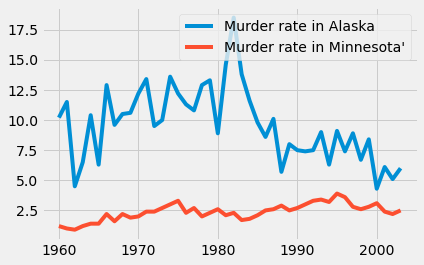

In [13]:
#Plot the Murder rates in Minnesota and Alaska in a line graph
y1 = ak_mn['Murder rate in Alaska']
y2 = ak_mn['Murder rate in Minnesota']
x = ak_mn['Year']

plt.plot(x, y1, label = "Murder rate in Alaska")
plt.plot(x, y2, label = "Murder rate in Minnesota'")
plt.legend()
plt.show()

In [14]:
# Compare the murder rates of any two states by filling in the blanks below 

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def state(state1, state2):
    state1_table = murder_rates[murder_rates['State'] == state1].drop(columns=['State', 'Population']).rename(columns={'Murder Rate': 'Murder Rate in {}'.format(state1)})
    state2_table = murder_rates[murder_rates['State'] == state2].drop(columns=['State', 'Population']).rename(columns={'Murder Rate': 'Murder Rate in {}'.format(state2)})
    
    s1_s2 = state1_table.merge(state2_table, left_on='Year', right_on='Year')
    
    s1_s2.plot('Year')
    plt.legend(bbox_to_anchor=(1.05, 1))
    plt.show()

states_array = murder_rates['State'].unique()

_ = interact(state,
             state1=widgets.Dropdown(options=list(states_array),value='California'),
             state2=widgets.Dropdown(options=list(states_array),value='New York')
            )

interactive(children=(Dropdown(description='state1', index=4, options=('Alaska', 'Alabama', 'Arkansas', 'Arizo…

Some US states have the death penalty, and others don't, and laws have changed over time. In addition to changes in murder rates, I will also consider in this analysis whether the death penalty was in force in each state and each year.

Using this information, I will investigate how the presence of the death penalty affects the murder rate of a state.

### A Natural Experiment

In order to attempt to investigate the causal relationship between the death penalty and murder rates, I used the *natural experiment* method.  A natural experiment happens when something other than experimental design applies a treatment to one group and not to another (control) group, and the data scientist hopes that the treatment and control groups don't have any other systematic differences.

My natural experiment is this: in 1972, a Supreme Court decision called *Furman v. Georgia* banned the death penalty throughout the US.  Suddenly, many states went from having the death penalty to not having the death penalty.

As a first step, I'll examine how murder rates changed before and after the court decision.  I'll define the test as follows:

> **Population:** All the states that had the death penalty before the 1972 abolition.  (There is no control group for the states that already lacked the death penalty in 1972, so we must omit them.)  This includes all US states **except** Alaska, Hawaii, Maine, Michigan, Wisconsin, and Minnesota.

> **Treatment group:** The states in that population, in 1973 (the year after 1972).

> **Control group:** The states in that population, in 1971 (the year before 1972).

> **Null hypothesis:** Murder rates in 1971 and 1973 come from the same distribution.

> **Alternative hypothesis:** Murder rates were higher in 1973 than they were in 1971.

The alternative hypothesis is related to my suspicion that murder rates increase when the death penalty is eliminated.  

I used an A/B test hypothesis to determine whether I could reject or accept the null hypothesis. 

In [18]:
non_death_penalty_states = np.array(['Alaska', 
                                     'Hawaii', 
                                     'Maine', 
                                     'Michigan', 
                                     'Wisconsin', 
                                     'Minnesota'])

In [19]:
def had_death_penalty_in_1971(state):
    """Returns True if the argument is the name of a state that 
    had the death penalty in 1971."""
    return state not in non_death_penalty_states

In [20]:
death_penalty = murder_rates['State'].unique()

death_penalty = pd.DataFrame({'State':death_penalty})

death_penalty['Death Penalty'] = death_penalty['State'].apply(had_death_penalty_in_1971)

death_penalty.head()

,State,Death Penalty
0,Alaska,False
1,Alabama,True
2,Arkansas,True
3,Arizona,True
4,California,True


In [23]:
#Table showing the states that the death penalty existed in 1971
preban_rates = pd.merge(death_penalty, murder_rates)
preban_rates = preban_rates[preban_rates['Year'] == 1971]
preban_rates = preban_rates.reset_index(drop=True)
preban_rates.head()

,State,Death Penalty,Year,Population,Murder Rate
0,Alaska,False,1971,313000,13.4
1,Alabama,True,1971,3479000,15.1
2,Arkansas,True,1971,1944000,10.5
3,Arizona,True,1971,1849000,6.7
4,California,True,1971,20223000,8.1


In [25]:
#Table showing the states that the death penalty existed in 1973

states_with_penalty = preban_rates['State']
postban_rates = pd.merge(death_penalty, murder_rates)
postban_rates = postban_rates[(postban_rates['Year'] == 1973)& (murder_rates['State'].isin(states_with_penalty))]
postban_rates = postban_rates.reset_index(drop=True)
postban_rates = postban_rates.sort_values(by=["State"])
postban_rates.head()

,State,Death Penalty,Year,Population,Murder Rate
1,Alabama,True,1973,3539000,13.2
0,Alaska,False,1973,330000,10.0
3,Arizona,True,1973,2058000,8.1
2,Arkansas,True,1973,2037000,8.8
4,California,True,1973,20601000,9.0


In [28]:
#Table with an added column "Murder rate Change" showing the change 
#of the murder rate before and after the death penalty ban

change_in_death_rates = preban_rates.copy()

change_in_death_rates = change_in_death_rates.append(postban_rates)

change_in_death_rates['73 Murder Rate'] = postban_rates['Murder Rate']

change = change_in_death_rates['73 Murder Rate'] - change_in_death_rates['Murder Rate']

change_in_death_rates['Murder Rate Change'] = change

change_in_death_rates


,State,Death Penalty,Year,Population,Murder Rate,73 Murder Rate,Murder Rate Change
0,Alaska,False,1971,313000,13.4,10.0,-3.400000
1,Alabama,True,1971,3479000,15.1,13.2,-1.900001
2,Arkansas,True,1971,1944000,10.5,8.8,-1.700000
3,Arizona,True,1971,1849000,6.7,8.1,1.400001
4,California,True,1971,20223000,8.1,9.0,0.900000
...,...,...,...,...,...,...,...
44,Virginia,True,1973,4811000,10.5,10.5,0.000000
46,Washington,True,1973,3429000,4.0,4.0,0.000000
48,West Virginia,True,1973,1794000,5.7,5.7,0.000000
47,Wisconsin,False,1973,4569000,2.6,2.6,0.000000


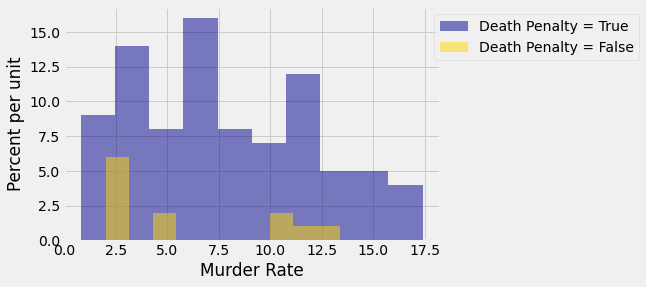

In [29]:
# Plot the distribution of the change in murder rates during the pre-ban and post-ban time periods.
pre_1972 = change_in_death_rates[change_in_death_rates['Death Penalty'] == True]
post_1972 = change_in_death_rates[change_in_death_rates['Death Penalty'] == False]

dp_pre = pre_1972['Murder Rate']
dp_post = post_1972['Murder Rate']

plt.hist(dp_pre, label='Death Penalty = True', alpha=0.5, color='darkblue', zorder=5)
plt.hist(dp_post, label='Death Penalty = False', alpha = 0.5, color='gold', zorder=10)
plt.xlabel('Murder Rate')
plt.ylabel('Percent per unit')
plt.legend(bbox_to_anchor=(1.55, 1))
plt.show();

This is a table `rate_means` containing the average murder rates for the states that had the death penalty and the states that didn't have the death penalty. It has two columns: one indicating if the penalty was in place, and one that contains the average murder rate for each group.

In [31]:
change_in_death_rates_copy = change_in_death_rates.copy()

#drop the unecaisery columns 
change_in_death_rates_copy = change_in_death_rates_copy.drop(columns=[ "Population", "73 Murder Rate", "Murder Rate Change"])

rate_means = change_in_death_rates_copy.groupby(by=(["Death Penalty"]))[["Murder Rate"]].mean()
rate_means


,Murder Rate
Death Penalty,
False,5.933333
True,7.817045


As I'm testing if murder rates were higher in 1973 than they were in 1971, my **test statistic** would be the difference between the avarege murder rates in 1973 to the average murder rates in 1971.

In [32]:
#observed_difference is the observed test statistic using the rate_means table
observed_difference = rate_means.iloc[1] - rate_means.iloc[0]
observed_difference

Murder Rate    1.883712
dtype: float64

In [35]:
def find_test_stat(table, labels_col, values_col):
    """Returns the observed test statistic of a pandas Dataframe given the mean of columns
    Input: dataframe, labels_col, values_col
    Output: test statistic -> float64"""
    table = table.copy()
    table = table.groupby(by=([labels_col]))[[values_col]].mean()
    observed_difference = table.iloc[1] - table.iloc[0]
    return observed_difference

In [36]:
find_test_stat(change_in_death_rates, "Death Penalty", "Murder Rate")

Murder Rate    1.883712
dtype: float64

When I run a simulation for A/B testing, I resample by shuffling the labels of the original sample. If the null hypothesis is true and the murder rate distributions are the same, I expect that the difference in mean death rates will not be changed when "Death Penalty" labels are changed.

In [38]:
def simulate_and_test_statistic(table, labels_col, values_col):
    """Computes one trial of our A/B test and returns a test statistic.
    Input: table, labels_col, values_col
    Output: test statistic -> float64"""
    
    random_labels = table[labels_col].sample(len(table), replace=False)
    random_labels = np.array(list(random_labels))
    table.loc[: , labels_col] = random_labels
    relabeled_tbl = table
    
    return find_test_stat(relabeled_tbl, labels_col, values_col)

In [39]:
simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")

Murder Rate    0.075
dtype: float64

I then run 5000 trials of my A/B test and stored the found test statistics in a numpy array called `differences`.

In [40]:
import datetime

differences = np.array([])

for i in np.arange(5000):
    simulate_AB_test = simulate_and_test_statistic(change_in_death_rates, "Death Penalty", "Murder Rate")
    differences = np.append(differences, simulate_AB_test)
                                                 
differences

array([ 0.18863629,  0.73787866,  0.29280304, ..., -0.50265149,
        1.30606061,  1.2965909 ])

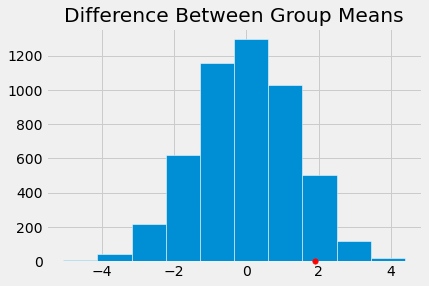

In [43]:
#Plot a histogram showing the distribution of my simulated test statistics with my observed statistic (red dot)
pd.DataFrame({'Difference Between Group Means':differences}).hist(ec='white', zorder=5)
plt.scatter(observed_difference, 0, color='red', s=30, zorder=10).set_clip_on(False);

In [44]:
differences = np.average(differences) 

#p-value
empirical_P = np.count_nonzero(differences >= observed_difference) / 10000   
empirical_P

0.0

As our p value is 0 then based on the 5% p-value cut-off we are likely to reject the null hypothesis, and accept the alternative one as the murder rates were higher after the abolishion of the death penalty.